#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩
    - pandas, numpy,matplotlib,seaborn, joblib 을 로딩하고
    필요한 라이브러리를 로딩합니다.
    <br>(분류 모델에서는 이번에 RandomForestClassifier를 씁니다. 더 많은 분류 모델을 써도 됩니다!)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns)
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [13]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(20,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [14]:
# 주어진 데이터 셋을 불러오세요.
data01_train =  pd.read_csv(path+'data01_train.csv')
data01_test = pd.read_csv(path+'data01_test.csv')
feature = pd.read_csv(path+'features.csv')

In [15]:
#불필요한 칼럼을 삭제하세요.
data01_train.drop('subject', axis=1, inplace=True)
data01_test.drop('subject', axis=1, inplace=True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [16]:
# 전체 데이터의 행, 열 개수를 확인

print(data01_train.shape)
print(data01_test.shape)

(5881, 562)
(1471, 562)


In [17]:
# 전체 데이터의 상위 5개 행 확인

data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [18]:
# 전체 데이터의 수치형 변수 분포 확인
data01_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [19]:
#전체 데이터의 모든 변수 확인
data01_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [20]:
#(추가) 다양하게 기본 정보들을 확인하세요!

data01_train.isnull().sum()

,0
tBodyAcc-mean()-X,0
tBodyAcc-mean()-Y,0
tBodyAcc-mean()-Z,0
tBodyAcc-std()-X,0
tBodyAcc-std()-Y,0
...,...
"angle(tBodyGyroJerkMean,gravityMean)",0
"angle(X,gravityMean)",0
"angle(Y,gravityMean)",0
"angle(Z,gravityMean)",0


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [21]:
# Activity 에 대해서 단변량 분석을 시행합니다. (범주별 빈도수, 종류, 비율, 시각화도 해보기!)

In [22]:
target = 'Activity'

data01_train[target].describe()

,Activity
count,5881
unique,6
top,LAYING
freq,1115


In [23]:
data01_train[target].unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [24]:
data01_train[target].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


<Axes: xlabel='Activity', ylabel='count'>

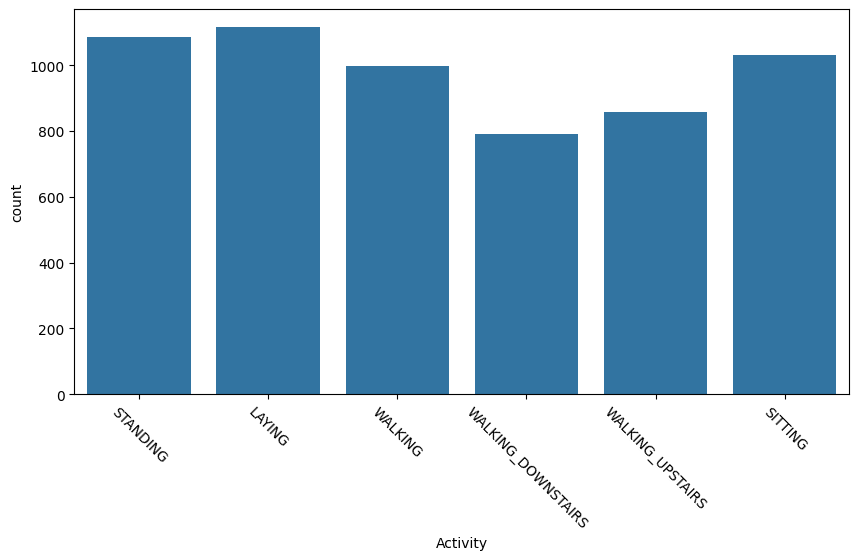

In [25]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=-45)
sns.countplot(x=target, data=data01_train)

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [26]:
#센서 그룹 데이터의 'sensor'변수의 값 확인

feature['sensor'].value_counts()

,count
sensor,
fBodyGyro,79
fBodyAccJerk,79
fBodyAcc,79
tBodyAcc,40
tGravityAcc,40
tBodyAccJerk,40
tBodyGyroJerk,40
tBodyGyro,40
tGravityAccMag,13


In [27]:
#센서 그룹 데이터의 'agg'변수의 값 확인

feature['agg'].value_counts()

,count
agg,
bandsEnergy(),126
arCoeff(),60
std(),33
mad(),33
max(),33
energy(),33
min(),33
entropy(),33
iqr(),33


In [28]:
#센서 그룹 데이터의 'axis'변수의 값 확인

feature['axis'].value_counts()

,count
axis,
X,76
Y,76
Z,76
gravityMean,6
"X,2",5
...,...
"17,32.2",2
"49,64.2",2
"1,24.2",2


## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [29]:
# 데이터 분할을 위한 전처리

x = data01_train.drop(target, axis=1)
y = data01_train[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=20)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

#### 2) 모델링

In [30]:
#생성
model = RandomForestClassifier(random_state=20)

#학습
model.fit(x_train, y_train)

#평가
print(model.score(x_val, y_val))

0.9762107051826678


#### 3) 변수 중요도 추출

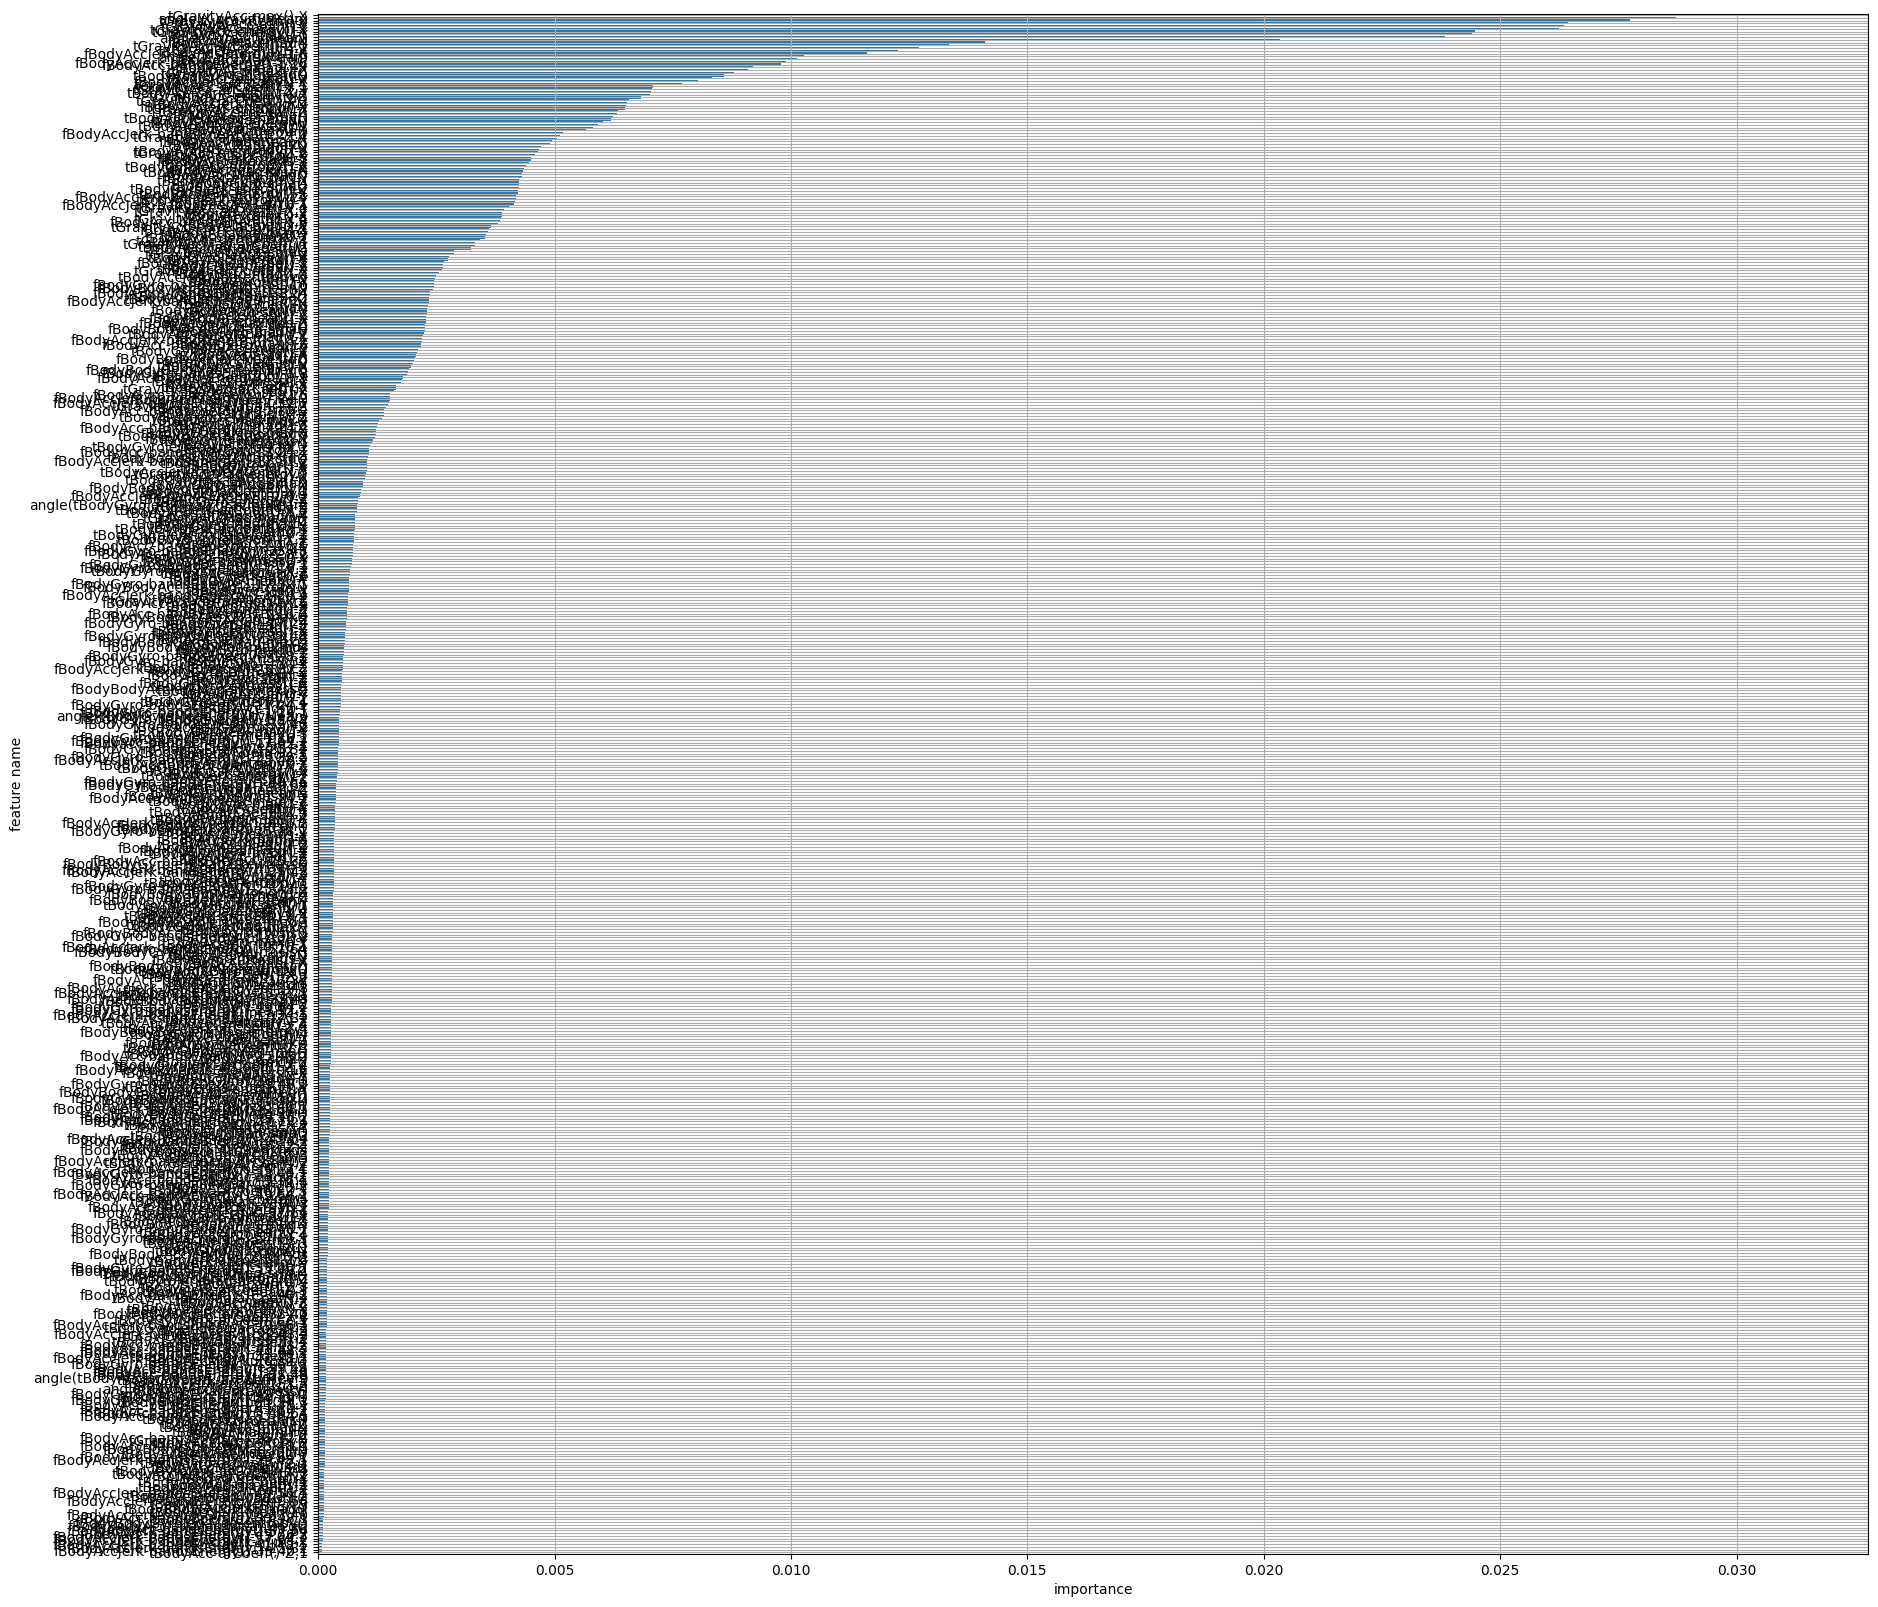

In [31]:
# 변수 중요도 추출(시각화로 나타내기)
fi_df = plot_feature_importance(model.feature_importances_, data01_train.drop(target, axis=1).columns)

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [32]:
# 중요도 상위 top 5
top5 = fi_df.head(5)

In [33]:
# 중요도 하위 top 5
bottom5 = fi_df.tail(5)

#### 2) 상위 5개 변수에 대한 분석
        - 위에서 나온 상위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

In [34]:
#1위 : oooo
first = top5.iloc[0]['feature_name']
second = top5.iloc[1]['feature_name']
thrid = top5.iloc[2]['feature_name']
forth = top5.iloc[3]['feature_name']
fifth = top5.iloc[4]['feature_name']

<Axes: xlabel='tGravityAcc-max()-X', ylabel='Density'>

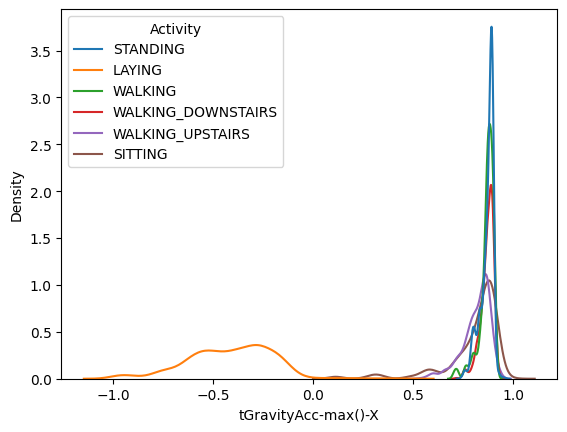

In [35]:
sns.kdeplot(data=data01_train, x=first, hue=target)

<Axes: xlabel='angle(X,gravityMean)', ylabel='Density'>

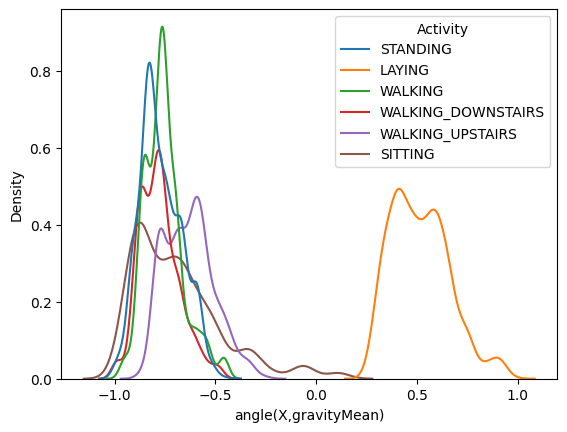

In [36]:
sns.kdeplot(data=data01_train, x=second, hue=target)

<Axes: xlabel='tGravityAcc-mean()-X', ylabel='Density'>

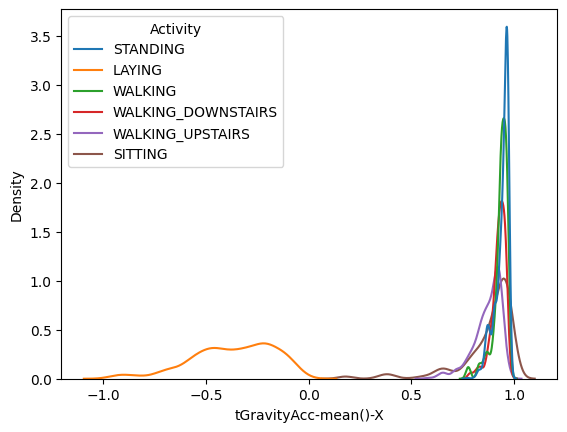

In [37]:
sns.kdeplot(data=data01_train, x=thrid, hue=target)

<Axes: xlabel='tGravityAcc-min()-Y', ylabel='Density'>

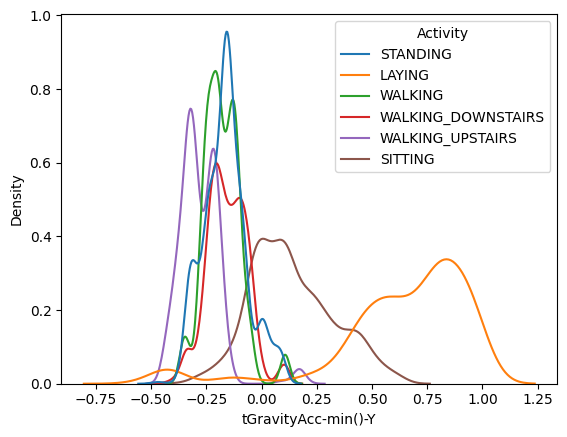

In [38]:
sns.kdeplot(data=data01_train, x=forth, hue=target)

<Axes: xlabel='tGravityAcc-mean()-Y', ylabel='Density'>

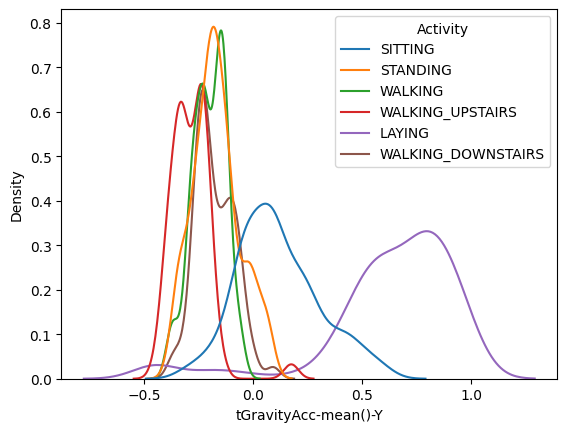

In [39]:
sns.kdeplot(data=data01_test, x=fifth, hue=target)

#### 3) 하위 5개 변수에 대한 분석
        - 위에서 하위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

1위  fBodyAccJerk-min()-X


<Axes: xlabel='fBodyAccJerk-min()-X', ylabel='Density'>

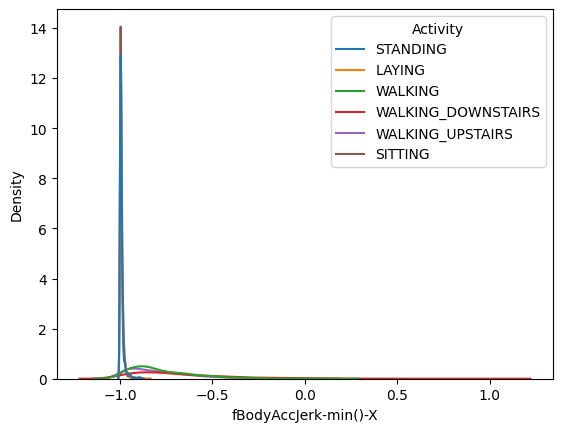

In [40]:
#1위 : oooo
first = bottom5.iloc[0]['feature_name']
print("1위 ", first)
sns.kdeplot(data=data01_train, x=first, hue=target)

2위  fBodyAccJerk-bandsEnergy()-41,48.1


<Axes: xlabel='fBodyAccJerk-bandsEnergy()-41,48.1', ylabel='Density'>

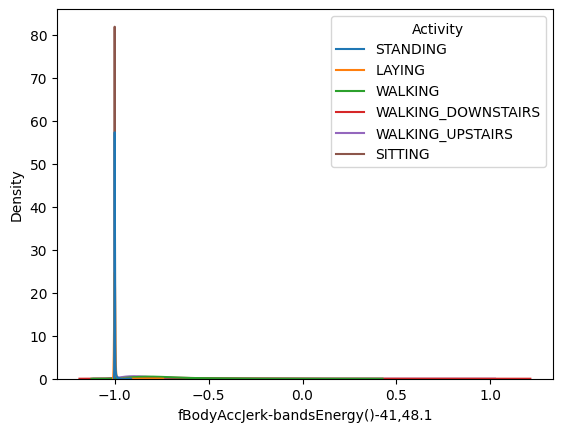

In [41]:
#2위: vvvvv
second = bottom5.iloc[1]['feature_name']
print("2위 ", second)
sns.kdeplot(data=data01_train, x=second, hue=target)

3위  fBodyAccJerk-bandsEnergy()-25,32


<Axes: xlabel='fBodyAccJerk-bandsEnergy()-25,32', ylabel='Density'>

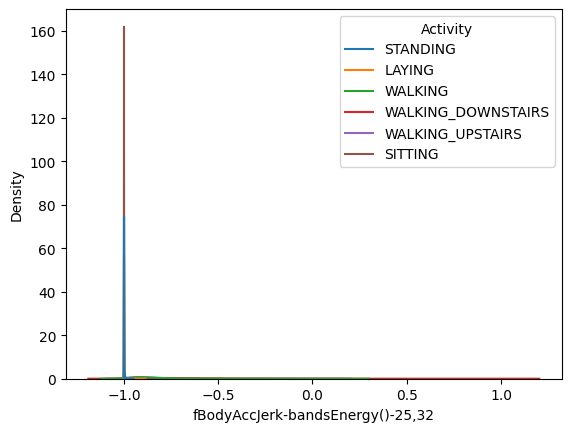

In [42]:
thrid = bottom5.iloc[2]['feature_name']
print("3위 ", thrid)
sns.kdeplot(data=data01_train, x=thrid, hue=target)

4위  fBodyAccJerk-bandsEnergy()-33,40.1


<Axes: xlabel='fBodyAccJerk-bandsEnergy()-33,40.1', ylabel='Density'>

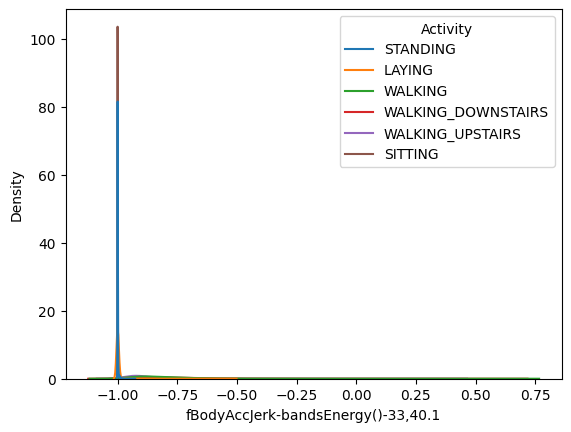

In [43]:
forth = bottom5.iloc[3]['feature_name']
print("4위 ", forth)
sns.kdeplot(data=data01_train, x=forth, hue=target)

5위  tBodyAcc-arCoeff()-Z,1


<Axes: xlabel='tBodyAcc-arCoeff()-Z,1', ylabel='Density'>

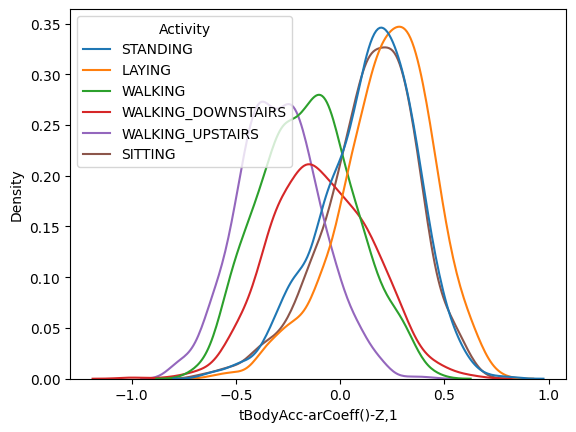

In [44]:
fifth = bottom5.iloc[4]['feature_name']
print("5위 ", fifth)
sns.kdeplot(data=data01_train, x=fifth, hue=target)

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.


#### 1) is_dynamic 추가

In [45]:
#is dynamic 변수를 추가하세요(값 0, 값 1 확인해서!)
static = ['STANDING', 'SITTING', "LAYING"]

data01_train['is_dynamic'] = data01_train['Activity'].apply(lambda x: 0 if x in static else 1)
data01_train.head(5)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


#### 2) 기본모델 생성

In [46]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x = data01_train.drop(['Activity', 'is_dynamic'], axis=1)
y = data01_train['is_dynamic']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state=20)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [47]:
#RandomForestClassifier로 모델링 진행
model = RandomForestClassifier(random_state=20)
model.fit(x_train, y_train)
print(model.score(x_val, y_val))

1.0


#### 3) 변수중요도 상위 5개 분석

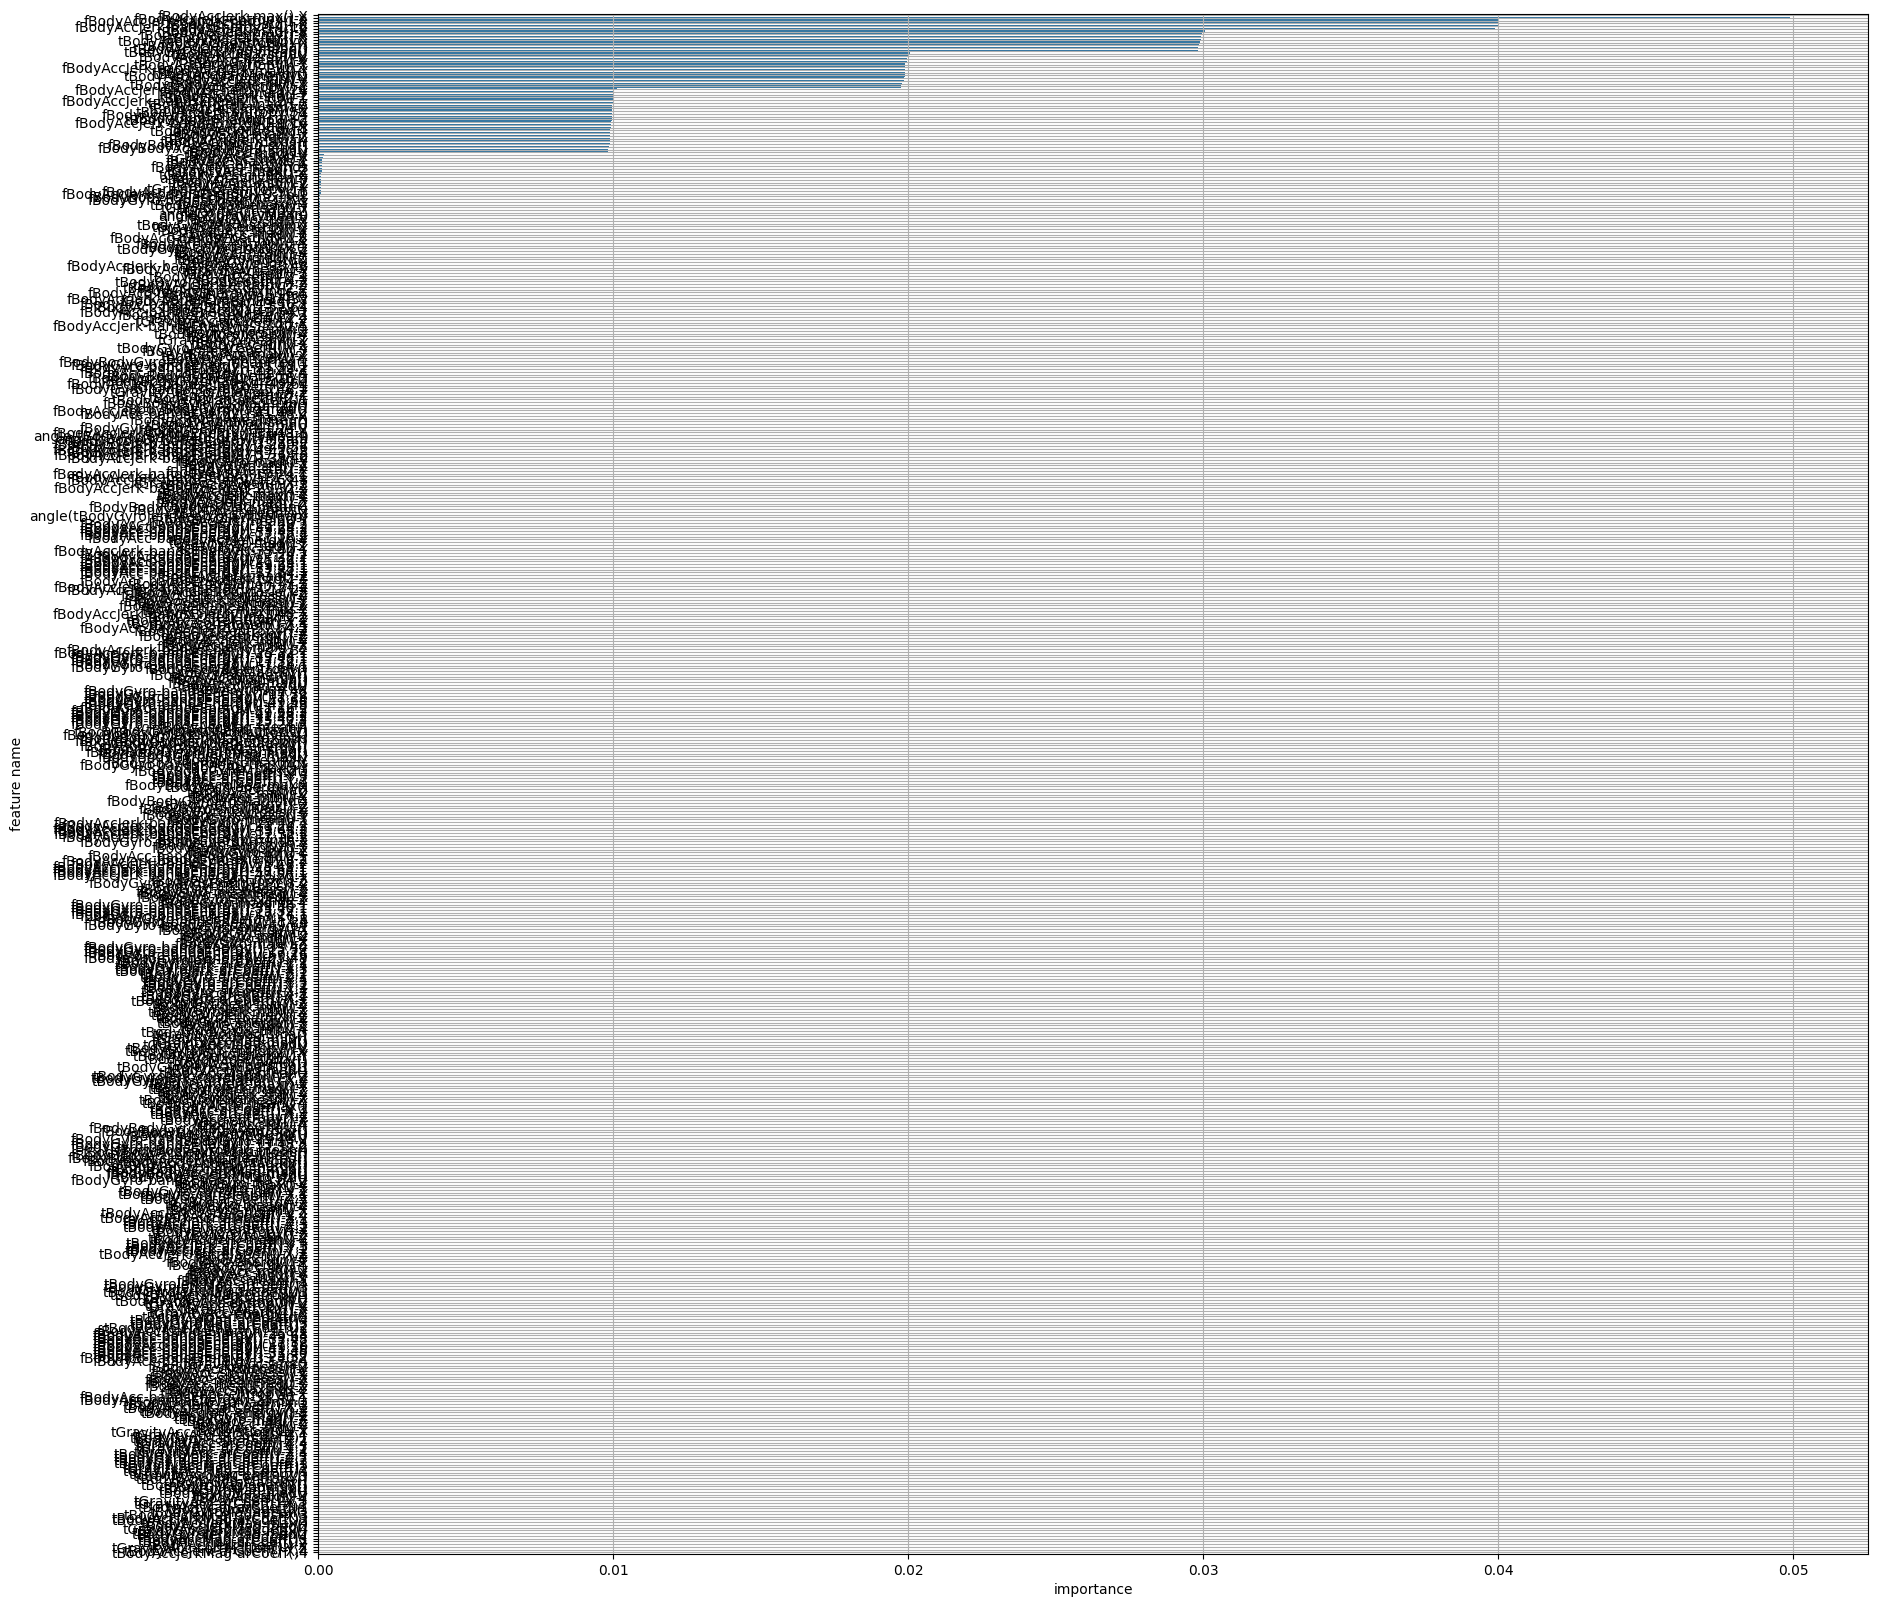

In [48]:
# is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석!
model.score(x_val, y_val)
fi_df_binary = plot_feature_importance(model.feature_importances_, data01_train.drop(['Activity', 'is_dynamic'], axis=1).columns)
top5 = fi_df_binary.head(5)

* 미션1에서 했던 것 처럼 상위 5개의 변수 데이터를 탐색해보기!

1위  fBodyAccJerk-max()-X


<Axes: xlabel='fBodyAccJerk-max()-X', ylabel='Density'>

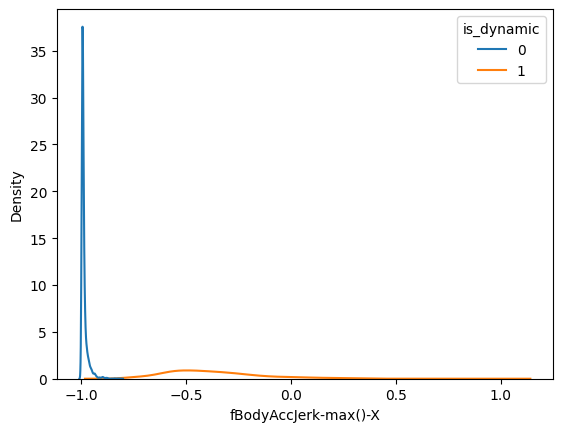

In [49]:
#1위:
first = top5.iloc[0]['feature_name']
print("1위 ", first)
sns.kdeplot(data=data01_train, x=first, hue='is_dynamic')

2위  fBodyAccJerk-entropy()-X


<Axes: xlabel='fBodyAccJerk-entropy()-X', ylabel='Density'>

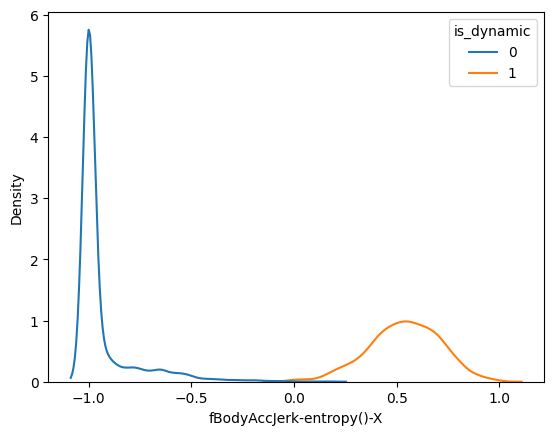

In [50]:
#2위:
second = top5.iloc[1]['feature_name']
print("2위 ", second)
sns.kdeplot(data=data01_train, x=second, hue='is_dynamic')

3위  fBodyAccJerk-bandsEnergy()-1,8


<Axes: xlabel='fBodyAccJerk-bandsEnergy()-1,8', ylabel='Density'>

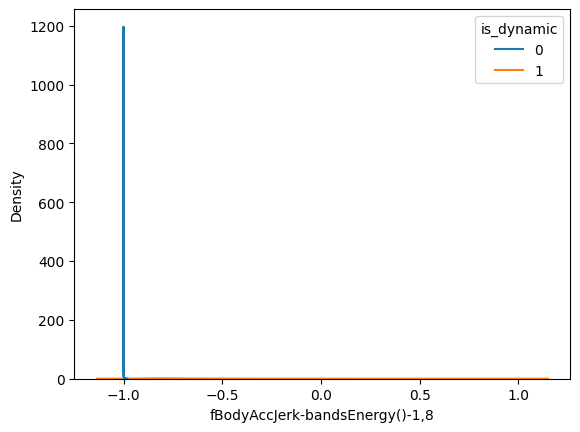

In [51]:
thrid = top5.iloc[2]['feature_name']
print("3위 ", thrid)
sns.kdeplot(data=data01_train, x=thrid, hue='is_dynamic')

4위  fBodyAccJerk-std()-X


<Axes: xlabel='fBodyAccJerk-std()-X', ylabel='Density'>

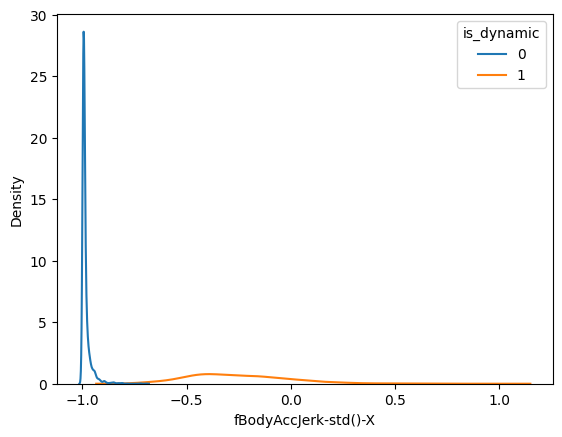

In [52]:
forth = top5.iloc[3]['feature_name']
print("4위 ", forth)
sns.kdeplot(data=data01_train, x=forth, hue='is_dynamic')

5위  fBodyAccJerk-bandsEnergy()-1,16


<Axes: xlabel='fBodyAccJerk-bandsEnergy()-1,16', ylabel='Density'>

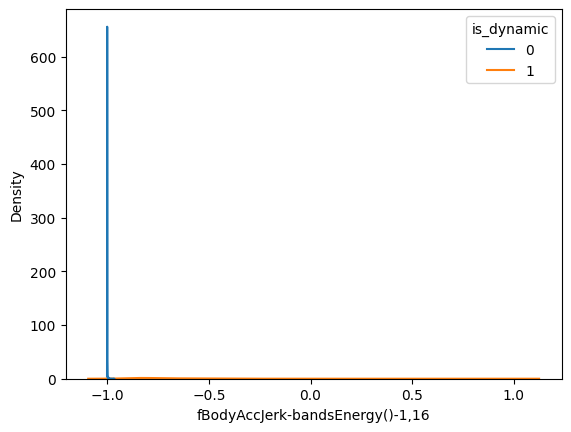

In [53]:
fifth = top5.iloc[4]['feature_name']
print("5위 ", fifth)
sns.kdeplot(data=data01_train, x=fifth, hue='is_dynamic')

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [54]:
# tip : rename을 써서 칼럼 이름 수정을 해야합니다!
fi_df.rename(columns={'feature_importance': 'importance_6actions'}, inplace=True)
fi_df_binary.rename(columns={'feature_importance': 'importance_binary'}, inplace=True)

print(fi_df.head())
print(fi_df_binary.head())

           feature_name  importance_6actions
0   tGravityAcc-max()-X             0.031222
1  angle(X,gravityMean)             0.028715
2  tGravityAcc-mean()-X             0.027737
3   tGravityAcc-min()-Y             0.026434
4  tGravityAcc-mean()-Y             0.026352
                      feature_name  importance_binary
0             fBodyAccJerk-max()-X           0.050033
1         fBodyAccJerk-entropy()-X           0.049871
2   fBodyAccJerk-bandsEnergy()-1,8           0.040027
3             fBodyAccJerk-std()-X           0.040008
4  fBodyAccJerk-bandsEnergy()-1,16           0.039983


#### 2) 합치기

In [55]:
# merge 해서 2개를 합치는 작업하기

fi_merged = pd.merge(fi_df, fi_df_binary, on='feature_name')
fi_merged

,feature_name,importance_6actions,importance_binary
0,tGravityAcc-max()-X,0.031222,0.000094
1,"angle(X,gravityMean)",0.028715,0.000060
2,tGravityAcc-mean()-X,0.027737,0.000112
3,tGravityAcc-min()-Y,0.026434,0.000026
4,tGravityAcc-mean()-Y,0.026352,0.000069
...,...,...,...
556,fBodyAccJerk-min()-X,0.000098,0.000000
557,"fBodyAccJerk-bandsEnergy()-41,48.1",0.000092,0.000000
558,"fBodyAccJerk-bandsEnergy()-25,32",0.000088,0.000000
559,"fBodyAccJerk-bandsEnergy()-33,40.1",0.000086,0.000000


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [56]:
# joblib.dump 이용해서 colab에 .pkl 파일에 저장하기(tip: path + '파일 이름.pkl')
import joblib

joblib.dump(fi_merged, path + 'feature_importance.pkl')

['/content/drive/MyDrive/project3/feature_importance.pkl']

#### 고생하셨습니다! 이제 기본 모델링을 해봅시다.